# ベイズ線形回帰（教師あり学習）

教師あり学習では{ (x_i,y_i) }のようなラベルの付いたデータからデータの隠された構造を推定するのが目的です。表題の回帰という語は出力変数yが連続的なときに用いられることが多いです。

ここではJupyterを用いてインタラクティブに動かせるEdwardの使用例をあげます。

In [9]:
import tensorflow as tf
import edward as ed

# Data

40個の点から構成される訓練用、テスト用のデータセットを用意します。データは$x_n \in \mathbb{R}^{10}, y_n \in \mathbb{R}$の組で、x_n,y_nは正規分布にしたがったノイズが加わった線形の関係があるものとします。

In [6]:
import numpy as np

def build_toy_dataset(N, w, noise_std=0.1):
  D = len(w)
  x = np.random.randn(N, D)
  y = np.dot(x, w) + np.random.normal(0, noise_std, size=N)
  return x, y

N = 40  # number of data points
D = 10  # number of features

w_true = np.random.randn(D) #係数wの真の値
X_train, y_train = build_toy_dataset(N, w_true)
X_test, y_test = build_toy_dataset(N, w_true)

# Model

ここではベイズ線形回帰モデル(Murphy, 2012[^1])を仮定します。入力$x_n \in \mathbb{R}^{D}$, 出力$y_n \in \mathbb{R}$間には線形の関係があるとします。

N個のデータ点
$(\mathbf{X},\mathbf{y})=\{(\mathbf{x}_n, y_n)\}(X,y)={(x_n,y_n}) $に対しモデルは以下の分布関数で表される関係を仮定しています。
\begin{aligned} p(\mathbf{w}) &= \text{Normal}(\mathbf{w} \mid \mathbf{0}, \sigma_w^2\mathbf{I}), \\[1.5ex] p(b) &= \text{Normal}(b \mid 0, \sigma_b^2), \\ p(\mathbf{y} \mid \mathbf{w}, b, \mathbf{X}) &= \prod_{n=1}^N \text{Normal}(y_n \mid \mathbf{x}_n^\top\mathbf{w} + b, \sigma_y^2).\end{aligned}

この線形モデルの隠れた変数は重み$\mathbf{w}$と切片(バイアスとも言う)b です。$\sigma_w^2,\sigma_b^2$は事前分布の分散、$\sigma_y^2$
は尤度の分散です。尤度の平均は入力 $\mathbf{x}_nx$ の線形変換として与えられています。

Edwardでモデルを書きましょう。$\sigma_w,\sigma_b,\sigma_y=1$
と固定すると

In [10]:
from edward.models import Normal

X = tf.placeholder(tf.float32, [N, D])
w = Normal(loc=tf.zeros(D), scale=tf.ones(D))
b = Normal(loc=tf.zeros(1), scale=tf.ones(1))
y = Normal(loc=ed.dot(X, w) + b, scale=tf.ones(N))

と書けます。ここでXはtensorflowのplaceholder[^2]です。推論処理の間、データに応じた値をこのpalceholderに渡すことになります。

# 推論

変分推論を用いた事後分布の推定に移ります。重みの各成分の値に対して完全に因数分解された(fully factorized)変分モデルを仮定します。

In [12]:
qw = Normal(loc=tf.Variable(tf.random_normal([D])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([D]))))
qb = Normal(loc=tf.Variable(tf.random_normal([1])),
            scale=tf.nn.softplus(tf.Variable(tf.random_normal([1]))))

カルバックライブラーダイバージェンス(Kullback-Leibler divergence)を使い5個の隠れた変数に対して250回イテレーション変分推論を行います。

In [13]:
inference = ed.KLqp({w: qw, b: qb}, data={X: X_train, y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 1s | Loss: 59.107


ここではKLqpクラスのデフォルトでは取り直されたパラメータの勾配(reparameterization gradient)を使って$\text{KL}(q\|p)$を最小化します。

推測処理の詳細は$\text{KL}(q\|p)$のチュートリアルを参照してください。

# Criticism

回帰問題の標準的な評価は予測の正確さを提供される"テスト"データと比較することでなされます。

ここでは事後予測分布を作ることでそれを行います。

In [14]:
y_post = ed.copy(y, {w: qw, b: qb})
#これは以下と等価
# y_post = Normal(loc=ed.dot(X, qw) + qb, scale=tf.ones(N))

これで様々な量をモデルを使った予測で評価することができます(事後予測)。

In [15]:
print("Mean squared error on test data:") #テストデータに対する二乗誤差
print(ed.evaluate('mean_squared_error', data={X: X_test, y_post: y_test}))

print("Mean absolute error on test data:") #テストデータに対する誤差の絶対値
print(ed.evaluate('mean_absolute_error', data={X: X_test, y_post: y_test}))

Mean squared error on test data:
0.0425247
Mean absolute error on test data:
0.169758


訓練されたモデルは(出力の大きさの絶対値にたいして)より小さな誤差で予測を行うことができます。

あらかじめ生成したデータと事後的に生成されたデータを比較することでそのあてはまり具合を可視化することもできます(ここでは画面が2次元なので出力と最初の特徴量のみです)。

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

def visualise(X_data, y_data, w, b, n_samples=10):
  w_samples = w.sample(n_samples)[:, 0].eval()
  b_samples = b.sample(n_samples).eval()
  plt.scatter(X_data[:, 0], y_data)
  inputs = np.linspace(-8, 8, num=400)
  for ns in range(n_samples):
    output = inputs * w_samples[ns] + b_samples[ns]
    plt.plot(inputs, output)

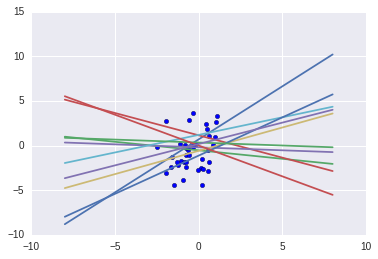

In [19]:
# 事前に生成したサンプルの可視化
visualise(X_train, y_train, w, b)

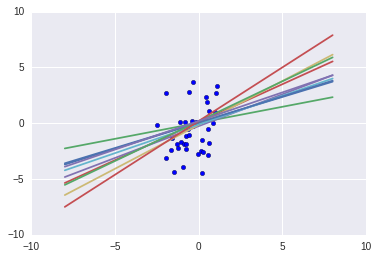

In [20]:
# 事後的にモデルから生成したサンプルの可視化
visualise(X_train, y_train, qw, qb)

モデルは$x \in\mathbb{R}^D$の最初の次元と出力$y\in\mathbb{R}$の間の線形の関係を学習していることがわかります。

# References

Murphy, K. P. (2012). Machine learning: A probabilistic perspective. MIT Press[^1].

# 訳注

[^2] tensorflowでは入力値など式の中で変化する値(変数)をplaceholderとして定義します。